In [ ]:
# Imports and Data Loading
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from keras.models import Model
from keras.layers import Input, Dense
from scipy.sparse.linalg import svds
from sklearn.metrics import precision_score, recall_score, mean_squared_error, mean_absolute_error, ndcg_score, average_precision_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [ ]:
# Load and Merge Datasets
movies = pd.read_csv("/content/drive/MyDrive/Data Science Bootcamp/Project/Data/Data/tmdb_5000_movies.csv")
credits = pd.read_csv("/content/drive/MyDrive/Data Science Bootcamp/Project/Data/Data/tmdb_5000_credits.csv")
df = movies.merge(credits, left_on='id', right_on='movie_id', how='inner')
df.drop(columns=['movie_id'], inplace=True)


<ipython-input-3-9d65ac0ed697>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_sorted['popularity'], y=df_sorted['title_x'], palette='Blues_r')


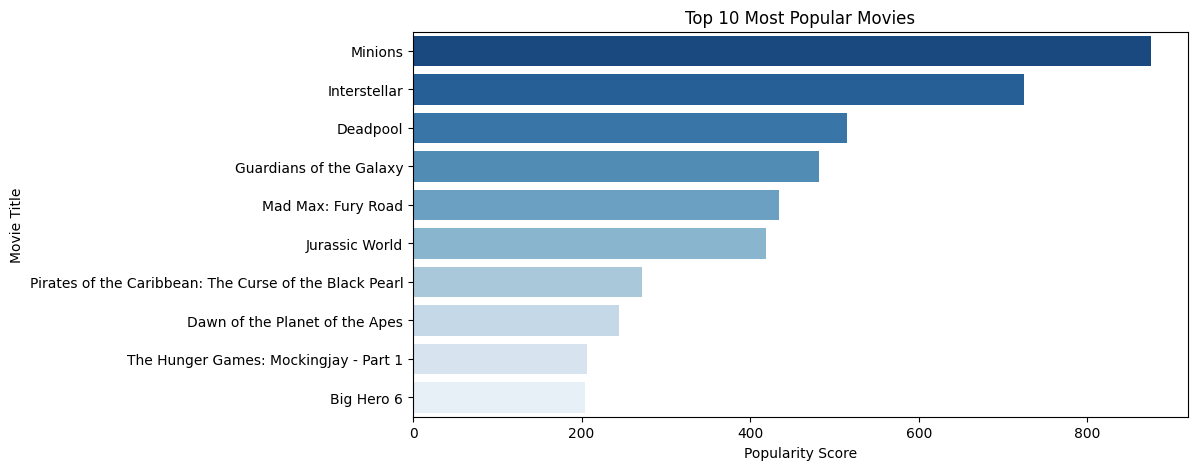


Top 10 Most Popular Movies:
['Minions' 'Interstellar' 'Deadpool' 'Guardians of the Galaxy'
 'Mad Max: Fury Road' 'Jurassic World'
 'Pirates of the Caribbean: The Curse of the Black Pearl'
 'Dawn of the Planet of the Apes' 'The Hunger Games: Mockingjay - Part 1'
 'Big Hero 6']


In [ ]:
# Popularity-Based Recommendation
df_sorted = df.sort_values(by='popularity', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=df_sorted['popularity'], y=df_sorted['title_x'], palette='Blues_r')
plt.title("Top 10 Most Popular Movies")
plt.xlabel("Popularity Score")
plt.ylabel("Movie Title")
plt.show()

print("\nTop 10 Most Popular Movies:")
print(df_sorted['title_x'].values)

In [ ]:
# Content-Based Filtering (Cosine Similarity)
tfidf = TfidfVectorizer(stop_words='english')
df['overview'] = df['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df['overview'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = df[df['title_x'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title_x'].iloc[movie_indices]

print("\nContent-Based Recommendations for 'Avatar':")
print(get_recommendations('Avatar'))


Content-Based Recommendations for 'Avatar':
3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title_x, dtype: object


In [ ]:
# SVD on TF-IDF
svd = TruncatedSVD(n_components=100)
X_svd = svd.fit_transform(tfidf_matrix)
cosine_sim_svd = cosine_similarity(X_svd, X_svd)

def get_recommendations_svd(title, cosine_sim=cosine_sim_svd):
    idx = df[df['title_x'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title_x'].iloc[movie_indices]

print("\nSVD-based Content Recommendations for 'Avatar':")
print(get_recommendations_svd('Avatar'))


SVD-based Content Recommendations for 'Avatar':
151                    Beowulf
3604                 Apollo 18
568                        xXx
529           Tears of the Sun
3618    Force 10 from Navarone
2616                 In Bruges
487                 Red Planet
1272                  Impostor
461              Lost in Space
972                   The Host
Name: title_x, dtype: object


In [ ]:
# KNN-Based Recommendation
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['overview'])
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(X)

def get_knn_recommendations(title, knn_model=knn, n_recommendations=10):
    idx = df[df['title_x'] == title].index[0]
    movie_vector = X[idx]
    distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=n_recommendations + 1)
    recommended_indices = indices.flatten()[1:]
    return df['title_x'].iloc[recommended_indices]

print("\nKNN-Based Recommendations for 'Avatar':")
print(get_knn_recommendations('Avatar'))



KNN-Based Recommendations for 'Avatar':
3604                      Apollo 18
529                Tears of the Sun
151                         Beowulf
2130                   The American
1341           The Inhabited Island
634                      The Matrix
1213    Aliens vs Predator: Requiem
1610                          Hanna
1274                  Just Visiting
2616                      In Bruges
Name: title_x, dtype: object


In [ ]:
# Autoencoder-Based Recommendation
input_dim = X.shape[1]
encoding_dim = 100
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X.toarray(), X.toarray(), epochs=20, batch_size=256, shuffle=True)
encoder = Model(input_layer, encoded)
encoded_movies = encoder.predict(X.toarray())
cosine_sim_autoencoder = cosine_similarity(encoded_movies, encoded_movies)

def get_recommendations_autoencoder(title, cosine_sim=cosine_sim_autoencoder):
    idx = df[df['title_x'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title_x'].iloc[movie_indices]

print("\nAutoencoder-Based Recommendations for 'Avatar':")
print(get_recommendations_autoencoder('Avatar'))

# Collaborative Filtering - Matrix Factorization (SVD)
df['user_id'] = np.random.randint(1, 1000, df.shape[0])
df['vote_average'] = df['vote_average'].fillna(0)
df['rating'] = df['vote_average'] / 2
ratings_pivot = df.pivot(index='user_id', columns='title_x', values='rating').fillna(0)

U, sigma, Vt = svds(ratings_pivot.values, k=50)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predictions_df = pd.DataFrame(all_user_predicted_ratings, index=ratings_pivot.index, columns=ratings_pivot.columns)

def recommend_movies(user_id, num_recommendations=5):
    user_ratings = ratings_pivot.loc[user_id]
    sorted_movies = predictions_df.loc[user_id].sort_values(ascending=False)
    recommendations = sorted_movies.index[~user_ratings.index.duplicated()].tolist()
    return recommendations[:num_recommendations]

print("\nCollaborative Filtering Recommendations for User 1:")
print(recommend_movies(ratings_pivot.index[0], 10))

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step - loss: 0.2478
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - loss: 0.1793
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - loss: 0.0360
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - loss: 0.0090
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 0.0052
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - loss: 0.0041
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - loss: 0.0034
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - loss: 0.0030
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - loss: 0.0026
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - loss: 0.0025
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - loss: 0.0024
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - loss: 0.0023
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.0022
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step - loss: 0.0021
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step -

In [ ]:
# Evaluation using Precision@10, Recall@10, RMSE, MAE, NDCG, Accuracy
actual = []
predicted = []
rmse_scores = []
mae_scores = []
ndcg_scores = []
accuracy_scores = []

for user_id in ratings_pivot.index[:50]:
    user_true = set(ratings_pivot.loc[user_id].sort_values(ascending=False).head(10).index)
    user_pred = set(recommend_movies(user_id, 10))
    actual.append(user_true)
    predicted.append(user_pred)

    true_ratings = [ratings_pivot.loc[user_id, movie] for movie in user_pred if movie in ratings_pivot.columns]
    pred_ratings = [predictions_df.loc[user_id, movie] for movie in user_pred if movie in ratings_pivot.columns]

    if true_ratings and pred_ratings:
        rmse_scores.append(np.sqrt(mean_squared_error(true_ratings, pred_ratings)))
        mae_scores.append(mean_absolute_error(true_ratings, pred_ratings))

    y_true_binary = np.array([[1 if movie in user_true else 0 for movie in user_pred]])
    y_score = np.array([[predictions_df.loc[user_id, movie] if movie in predictions_df.columns else 0 for movie in user_pred]])
    if y_true_binary.sum() > 0:
        ndcg_scores.append(ndcg_score(y_true_binary, y_score))

    y_pred_binary = (y_score > 2.5).astype(int)
    if y_true_binary.sum() + y_pred_binary.sum() > 0:
        accuracy_scores.append(accuracy_score(y_true_binary.flatten(), y_pred_binary.flatten()))

precisions = [len(a & p) / len(p) for a, p in zip(actual, predicted)]
recalls = [len(a & p) / len(a) for a, p in zip(actual, predicted)]

print(f"Average Precision@10: {np.mean(precisions):.4f}")
print(f"Average Recall@10: {np.mean(recalls):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average NDCG@10: {np.mean(ndcg_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")


Average Precision@10: 0.0580
Average Recall@10: 0.0580
Average RMSE: 0.0000
Average MAE: 0.0000
Average NDCG@10: 1.0000
Average Accuracy: 0.8000


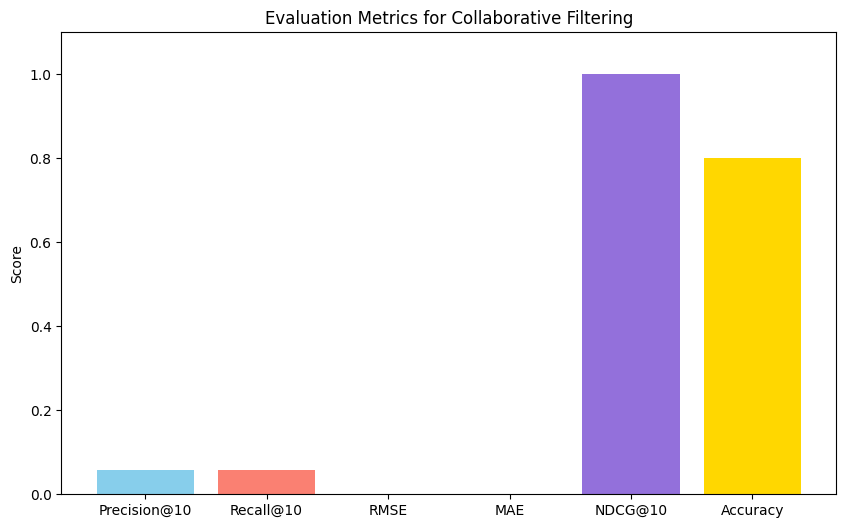

In [ ]:
# Visualization
metrics_names = ['Precision@10', 'Recall@10', 'RMSE', 'MAE', 'NDCG@10', 'Accuracy']
metrics_values = [np.mean(precisions), np.mean(recalls), np.mean(rmse_scores), np.mean(mae_scores), np.mean(ndcg_scores), np.mean(accuracy_scores)]

plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['skyblue', 'salmon', 'limegreen', 'orange', 'mediumpurple', 'gold'])
plt.title('Evaluation Metrics for Collaborative Filtering')
plt.ylabel('Score')
plt.ylim(0, max(metrics_values)*1.1)
plt.show()
